In [1]:
import pandas as pd
import sys
sys.path.append('../')
from utils.abstract_utils import read_abstracts_file

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_686495/2595349252.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Explore data

## Load abstract

In [2]:
filename = "../data/abstracts.cat"

abstracts_df = read_abstracts_file(filename)

# Drop rows with missing Cycle
abstracts_df = abstracts_df.dropna(subset=['Cycle'])
abstracts_df = abstracts_df[abstracts_df['Cycle'] != '']

# Convert Cycle and ID to int
abstracts_df['Cycle'] = abstracts_df['Cycle'].astype(int)
abstracts_df['ID'] = abstracts_df['ID'].astype(int)

In [3]:
abstracts_df.head()

,Prop. Type,Category,ID,Cycle,Title,PI,Abstract
0,ENG/STIS/PAR,,10000,12,STIS Pure Parallel Imaging Program: Cycle 12,Paul Goudfrooij,This is the default archival pure parallel pr...
1,GO,GALAXIES,10001,12,Locating Ultraluminous X-Ray Sources,Philip Kaaret,We propose to observe ultraluminous X-ray sou...
2,GO,AGN,10002,12,Detailed Study of X-ray Jets from a Complete S...,Eric Perlman,We propose deep followup HST and Chandra obse...
3,GO,GALAXIES,10003,12,Deep Chandra and Hubble Observations of NGC469...,Craig Sarazin,We propose 4 new Chandra observations of NGC4...
4,GO,AGN,10004,12,The Physics of Relativistic Jets: Chandra Imag...,F. Tavecchio,Extended jets have been a key target for Chan...


In [4]:
# Only keep specific Cycles

cycle_min = 0
cycle_max = 32

abstracts_cycle_df = abstracts_df[(abstracts_df['Cycle'] >= cycle_min) & (abstracts_df['Cycle'] <= cycle_max)]

In [5]:
# abstract_ids = abstracts_cycle_df['ID'].values
# abstracts_cycle_df['Cycle'].value_counts()

In [6]:
# import os

# def remove_large_files(directory, size_limit=2*1024*1024):  # default size_limit is set to 2MB
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             filepath = os.path.join(foldername, filename)
#             if os.path.getsize(filepath) > size_limit:
#                 try:
#                     os.remove(filepath)
#                     print(f"Removed {filepath}")
#                 except Exception as e:
#                     print(f"Error removing {filepath}: {e}")

# directory_path = '../data/observations_v2/'
# remove_large_files(directory_path)

## Load summaries

In [7]:
summaries_filename = "../data/summary_v2.csv"

summaries_df = pd.read_csv(summaries_filename)

In [8]:
summaries_df.head()

,proposal_id,objects_phenomena,science_use_cases
0,14743,"Superluminous supernova SN 2015bn, magnetar, c...","Constrain explosion mechanism of SN 2015bn, di..."
1,6507,"spiral density waves, dwarf galaxies, irregula...",determine ages of stellar populations in NGC 3...
2,14249,"neutron stars, pulsars, radio-pulsars, PSR J01...",understand long-term evolution of neutron star...
3,8781,"NGC 2363, extragalactic giant H II region, Lum...","monitor variations of LBV's mass loss rate, te..."
4,10556,"Damped Lyman-alpha systems, neutral hydrogen g...",Study evolution of neutral gas phase component...


In [9]:
summaries_df[summaries_df["proposal_id"] == 10520]["objects_phenomena"].values[0]

'Leo I dSph, color-magnitude diagrams, stellar populations, stellar evolutionary models, spectroscopy'

## Data loader

In [10]:
import os
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import random

2024-06-05 20:47:58.654493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 20:47:58.661695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 20:47:59.004115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(abstract, summary, image):

    height, width = image.shape[:2]

    # Encode abstract to bytes
    abstract_bytes = abstract.encode('utf-8')  
    summary_bytes = summary.encode('utf-8')  

    # Convert image to bytes
    image_bytes = image.tobytes()

    feature = {
        'abstract': _bytes_feature(abstract_bytes),
        'summary': _bytes_feature(summary_bytes),
        'image': _bytes_feature(image_bytes),
        'image_height': _int64_feature(height),
        'image_width': _int64_feature(width)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(abstracts, summaries, images, filename, metadata_file):
    with tf.io.TFRecordWriter(filename) as writer:
        for abstract, summary, image in zip(abstracts, summaries, images):
            tf_example = serialize_example(abstract, summary, image)
            writer.write(tf_example)
    
    # Write metadata to the auxiliary file
    with open(metadata_file, 'a') as meta_file:
        meta_file.write(f"{filename}: {len(images)} images\n")

In [12]:
# import matplotlib.pyplot as plt

# image = Image.open("../data/observations_v1/proposal_10001/hst_10001_01_acs_wfc_total_j8vo01_drc.jpg").convert("RGB")
# image = np.array(image)

# # Pad image to square
# h, w, c = image.shape
# max_dim = max(h, w)
# padded_image = np.ones((max_dim, max_dim, c), dtype=np.uint8) * 255

# # Calculate top and left padding
# y_offset = (max_dim - h) // 2
# x_offset = (max_dim - w) // 2

# padded_image[y_offset : y_offset + h, x_offset : x_offset + w, :] = image

# plt.imshow(padded_image)

In [13]:
def get_abstracts_and_images_and_write_tfrecords(data_folder, tfrecords_folder, abstracts_cycle_df, summaries_df, num_tfrecords, num_train_tfrecords):
    
    # Lists to store results
    images_list = []
    abstracts_list = []
    summaries_list = []

    # Collect directories that contain .jpg files and match the "proposal_" pattern, excluding unwanted directories
    directories_with_images = [os.path.join(r, d)
                               for r, dirs, files in os.walk(data_folder)
                               for d in dirs
                               if d.startswith("proposal_") and not d.endswith('.ipynb_checkpoints')]

    # Shuffle the list of directories
    random.shuffle(directories_with_images)

    # Get the total number of jpg files to be processed for the progress bar
    total_files = sum([len(files) for r, d, files in os.walk(data_folder) if any(file.endswith('.jpg') for file in files)])

    # Calculate the chunk size
    chunk_size = total_files // num_tfrecords if total_files >= num_tfrecords else 1

    print(f"Chunk size is {chunk_size}")

    # Initialize the progress bar
    pbar = tqdm(total=total_files, desc='Processing Images')

    # Initialize the file number
    file_num = 1
    metadata_file = f'{tfrecords_folder}/metadata.txt'
    
    # Clear the metadata file if it exists
    if os.path.exists(metadata_file):
        os.remove(metadata_file)

    # Create tfrecords folder if it doesn't exist
    os.makedirs(tfrecords_folder, exist_ok=True)

    # Walk through data folder
    for directory in directories_with_images:
        for file in os.listdir(directory):
            if file.endswith(".jpg"):
                
                image_path = os.path.join(directory, file)
                proposal_id = directory.split("proposal_")[-1]  # Extract proposal id from the directory name
                
                # Extract abstract using the dataframe
                abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]
                category = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Category"].values[0]

                objects_phenomena = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["objects_phenomena"].values[0]
                science_use_cases = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["science_use_cases"].values[0]

                summary = f"{objects_phenomena}; {science_use_cases}"

                if category is not None:
                    abstract = f"Category: {category}. {abstract}"
                    
                image = Image.open(image_path).convert("RGB")
                image = np.array(image)

                # Pad image to square
                h, w, c = image.shape
                max_dim = max(h, w)
                padded_image = np.ones((max_dim, max_dim, c), dtype=np.uint8) * 255

                # Calculate top and left padding
                y_offset = (max_dim - h) // 2
                x_offset = (max_dim - w) // 2

                padded_image[y_offset : y_offset + h, x_offset : x_offset + w, :] = image
                
                images_list.append(padded_image)
                abstracts_list.append(abstract)
                summaries_list.append(summary)
                
                pbar.update(1)  # Update the progress bar

                # If the length of the lists reaches the chunk size, write to a TFRecord file
                if len(images_list) >= chunk_size:
                    print(f"Writing record {file_num}")

                    # Either train or val
                    if file_num <= num_train_tfrecords:
                        filename = f"{tfrecords_folder}/observations_train_{file_num}.tfrecord"
                    else:
                        filename = f"{tfrecords_folder}/observations_val_{file_num}.tfrecord"
                        
                    write_tfrecord(abstracts_list, summaries_list, images_list, filename, metadata_file)
                    
                    # Reset the images and abstracts lists
                    images_list = []
                    abstracts_list = []
                    summaries_list = []
                    
                    file_num += 1  # Increment the file number

    # Write the remaining records to a TFRecord file if any
    if images_list:
        print(f"Writing final record {file_num}")
        filename = f"{tfrecords_folder}/observations_val_{file_num}.tfrecord"
        write_tfrecord(abstracts_list, summaries_list, images_list, filename, metadata_file)

    pbar.close()  # Close the progress bar

tfrecords_folder = "/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/"
data_folder = "../data/observations_v1/"
num_tfrecords = 10
num_train_tfrecords = 9

get_abstracts_and_images_and_write_tfrecords(data_folder, tfrecords_folder, abstracts_cycle_df, summaries_df, num_tfrecords, num_train_tfrecords)

Chunk size is 3185


Processing Images:   0%|          | 0/31859 [00:00<?, ?it/s]

Writing record 1
Writing record 2
Writing record 3
Writing record 4
Writing record 5
Writing record 6
Writing record 7
Writing record 8
Writing record 9
Writing record 10
Writing final record 11


## Images and abstracts for paper; Table 2

In [15]:
import matplotlib.pyplot as plt
import random
import pandas as pd
from PIL import Image
import numpy as np

data_folder = "../data/observations_v1/"
save_dir = "../paper/plots/data/"

# Collect directories that contain .jpg files and match the "proposal_" pattern, excluding unwanted directories
directories_with_images = [os.path.join(r, d)
                           for r, dirs, files in os.walk(data_folder)
                           for d in dirs
                           if d.startswith("proposal_") and not d.endswith('.ipynb_checkpoints')]
random.seed(99999)
random.seed(1e9 + 5345)
random.shuffle(directories_with_images)

# fig, ax = plt.subplots(1, 4, figsize=(20,4))

ii = 0

for directory in directories_with_images[:4]:
    proposal_id = directory.split("proposal_")[-1]  # Extract proposal id from the directory name

    for file in os.listdir(directory)[0:1]:
        if file.endswith(".jpg"):      
            image_path = os.path.join(directory, file)
            image = Image.open(image_path).convert("RGB")
            image = np.array(image)

            # Pad image to square
            h, w, c = image.shape
            max_dim = max(h, w)
            padded_image = np.ones((max_dim, max_dim, c), dtype=np.uint8) * 255

            # Calculate top and left padding
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2

            padded_image[y_offset : y_offset + h, x_offset : x_offset + w, :] = image

            # ax[ii].imshow(padded_image)

            # Extract abstract using the dataframe
            abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]
            category = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Category"].values[0]

            objects_phenomena = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["objects_phenomena"].values[0]
            science_use_cases = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["science_use_cases"].values[0]

            summary = f"{objects_phenomena}; {science_use_cases}"

            with open(save_dir + f"/sum_{ii}.txt", 'w') as file:
                file.write(summary)

            with open(save_dir + f"/abs_{ii}.txt", 'w') as file:
                file.write(abstract)

            with open(save_dir + f"/id_{ii}.txt", 'w') as file:
                url = f"\\href{{https://archive.stsci.edu/proposal_search.php?id={proposal_id}&mission=hst}}{{{proposal_id}}}"
                file.write(url)
                
            with open(save_dir + f"/cycle_{ii}.txt", 'w') as file:
                file.write(str(abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Cycle"].values[0]))

            plt.figure(figsize=(8,8))
            plt.imshow(padded_image)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(save_dir + f"/img_{ii}.pdf")
            plt.close()

            ii += 1

## Abstracts and summaries; Table 1

In [20]:
data_folder = "../data/observations_v1/"
save_dir = "../paper/plots/data/"

# Collect directories that contain .jpg files and match the "proposal_" pattern, excluding unwanted directories
directories_with_images = [os.path.join(r, d)
                           for r, dirs, files in os.walk(data_folder)
                           for d in dirs
                           if d.startswith("proposal_") and not d.endswith('.ipynb_checkpoints')]
random.seed(99999)
random.seed(1e9 + 5345)
random.shuffle(directories_with_images)

ii = 0
n_max_words = 55

for directory in directories_with_images[:4]:
    proposal_id = directory.split("proposal_")[-1]  # Extract proposal id from the directory name

    for file in os.listdir(directory)[0:1]:
        if file.endswith(".jpg"):      
            image_path = os.path.join(directory, file)
            image = Image.open(image_path).convert("RGB")
            image = np.array(image)

            # Extract abstract using the dataframe
            abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]
            category = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Category"].values[0]

            objects_phenomena = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["objects_phenomena"].values[0]
            science_use_cases = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["science_use_cases"].values[0]

            if category is not None and category.strip(" ") is not "":
                abstract = f"Category: {category}. {abstract}"

            with open(save_dir + f"/sci1_{ii}.txt", 'w') as file:
                file.write(science_use_cases)

            with open(save_dir + f"/obj1_{ii}.txt", 'w') as file:
                file.write(objects_phenomena)

            with open(save_dir + f"/id1_{ii}.txt", 'w') as file:
                file.write(proposal_id)

            with open(save_dir + f"/abs1_{ii}.txt", 'w') as file:
                file.write(' '.join(abstract.split()[:n_max_words]) + '...')

            with open(save_dir + f"/cycle1_{ii}.txt", 'w') as file:
                file.write(str(abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Cycle"].values[0]))

            ii += 1

<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_144846/2593457559.py:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if category is not None and category.strip(" ") is not "":


In [22]:
len(summaries_df)

4438

<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_127432/2690260235.py:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if category is not None and category.strip(" ") is not "":


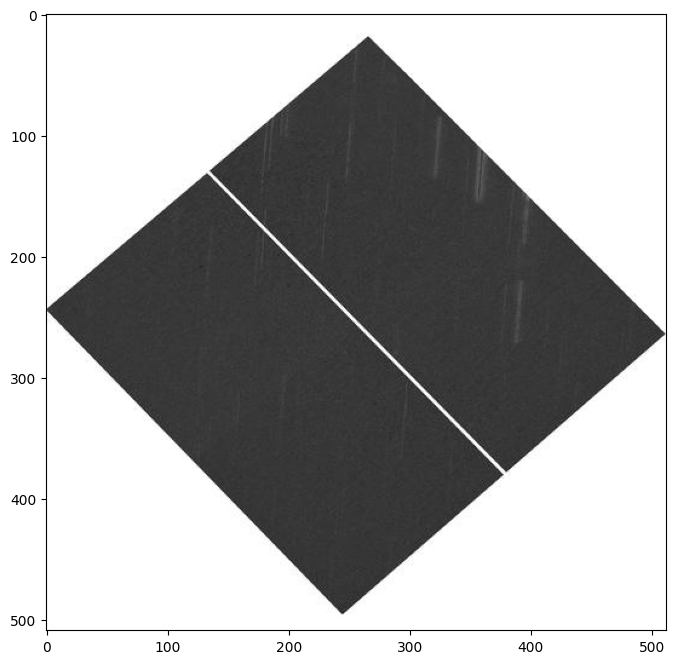

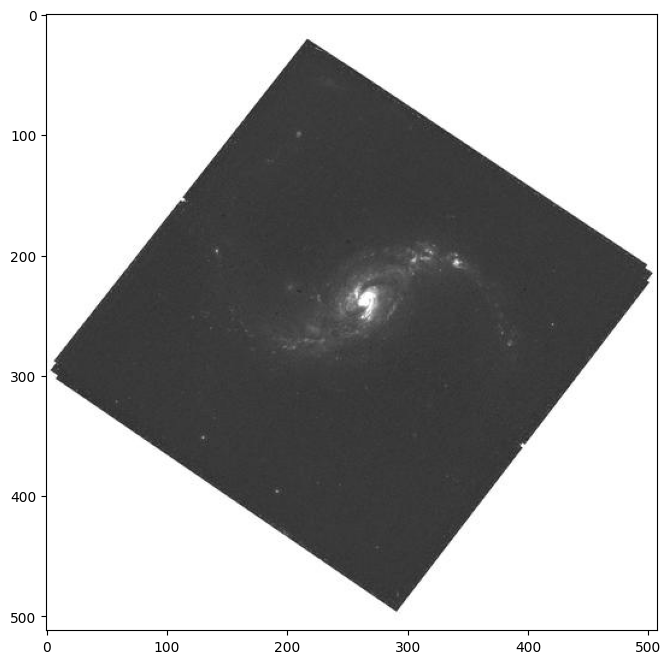

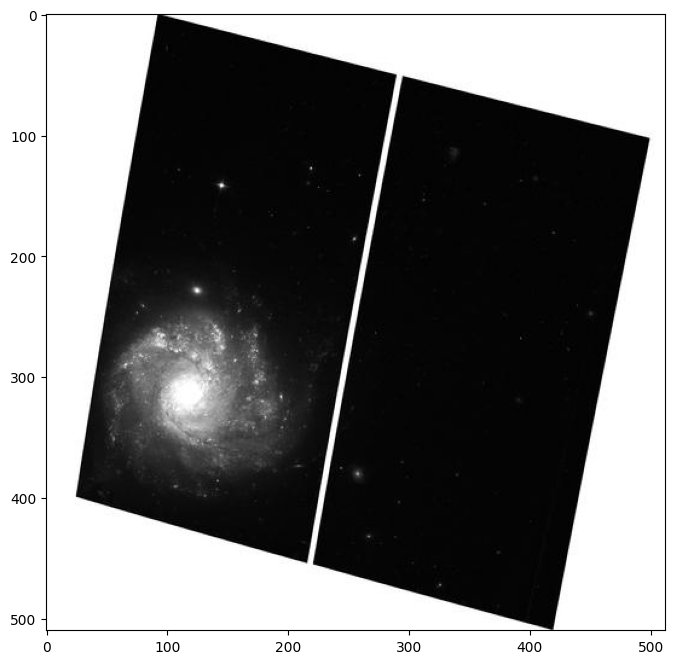

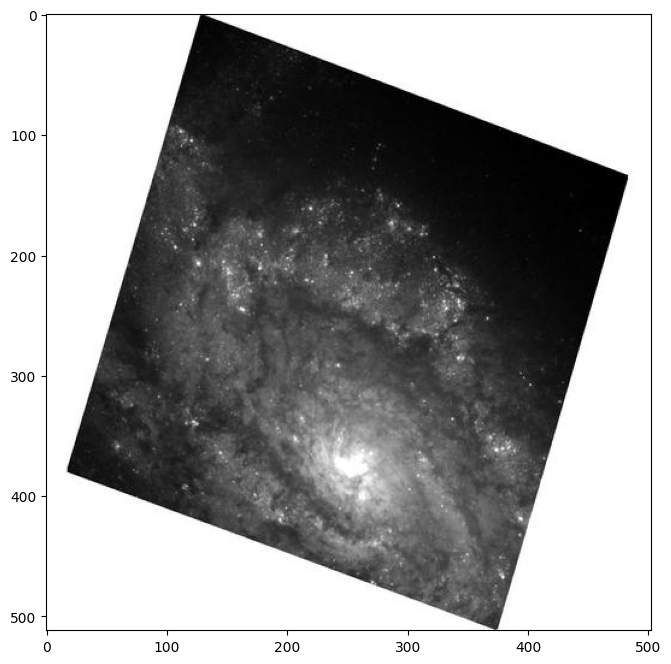

In [17]:
import matplotlib.pyplot as plt

data_folder = "../data/observations_v1/"
save_dir = "../paper/plots/data/"

# Collect directories that contain .jpg files and match the "proposal_" pattern, excluding unwanted directories
directories_with_images = [os.path.join(r, d)
                           for r, dirs, files in os.walk(data_folder)
                           for d in dirs
                           if d.startswith("proposal_") and not d.endswith('.ipynb_checkpoints')]
random.seed(99999)
random.seed(1e1 + 43223)
random.shuffle(directories_with_images)

ii = 0
n_max_words = 55

for directory in directories_with_images[:4]:
    proposal_id = directory.split("proposal_")[-1]  # Extract proposal id from the directory name

    for file in os.listdir(directory)[0:1]:
        if file.endswith(".jpg"):      
            image_path = os.path.join(directory, file)
            image = Image.open(image_path).convert("RGB")
            image = np.array(image)

            # Extract abstract using the dataframe
            abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]
            category = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Category"].values[0]

            objects_phenomena = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["objects_phenomena"].values[0]
            science_use_cases = summaries_df[summaries_df["proposal_id"] == int(proposal_id)]["science_use_cases"].values[0]

            if category is not None and category.strip(" ") is not "":
                abstract = f"Category: {category}. {abstract}"

            with open(save_dir + f"/sci_im_{ii}.txt", 'w') as file:
                file.write(science_use_cases)

            with open(save_dir + f"/obj_im_{ii}.txt", 'w') as file:
                file.write(objects_phenomena)

            with open(save_dir + f"/id_im_{ii}.txt", 'w') as file:
                file.write(proposal_id)

            with open(save_dir + f"/abs_im_{ii}.txt", 'w') as file:
                file.write(' '.join(abstract.split()[:n_max_words]) + '...')

            with open(save_dir + f"/cycle_im_{ii}.txt", 'w') as file:
                file.write(str(abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Cycle"].values[0]))

            # Save image
            plt.figure(figsize=(8,8))
            plt.imshow(image)

            ii += 1